### Step 1: Install necesscary packages

In [1]:
# !pip install matplotlib
# !pip install torch numpy transformers datasets tiktoken wandb tqdm

### Step 2: Package imports and configuration

In [2]:
import sys
import os

sys.path.append(os.path.abspath("..")) 
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pickle
from model import GPT, GPTConfig
import random
from tqdm import tqdm
import time
import json
import matplotlib.pyplot as plt
# Configuration
beta = 0.5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_lr = 1e-4
epochs = 50
batch_size = 64
max_length =64
num_samples = 1
max_new_tokens = 200
temperature = 0.8
top_k = 200
# tokenizer

with open("../sft/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])

seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
print(f"Device being used: {device}")

Device being used: cuda


### Step 3: Define helper functions

In [3]:
def compute_logprob(input_ids):
    inputs = input_ids[:, :-1]
    targets = input_ids[:, 1:]
    logits, _ = gpt(inputs, full_seq=True)
    B, T, V = logits.size()
    logits_flat = logits.reshape(-1, V)
    targets_flat = targets.reshape(-1)
    loss = F.cross_entropy(logits_flat, targets_flat, ignore_index=0, reduction='none')
    loss = loss.reshape(B, T)
    attention_mask = (targets != 0).float()
    loss = (loss * attention_mask).sum(dim=1) / attention_mask.sum(dim=1)
    return -loss 

def pad_or_truncate(seq, max_length):
    return seq[-max_length:] if len(seq) > max_length else seq + [0] * (max_length - len(seq))

def get_batches(lines, batch_size):
    random.shuffle(lines)
    #for l in lines:
    #    print(l[1])
    for i in range(0, len(lines), batch_size):
        batch = lines[i:i+batch_size]
        if len(batch) < batch_size:
            continue
        neg_inputs = [pad_or_truncate(encode(p['negative'] + '\n\n\n\n'), max_length) for p in batch]
        pos_inputs = [pad_or_truncate(encode(p['positive'] + '\n\n\n\n'), max_length) for p in batch]
        neg_tensor = torch.tensor(neg_inputs, dtype=torch.long, device=device)
        pos_tensor = torch.tensor(pos_inputs, dtype=torch.long, device=device)
        yield neg_tensor, pos_tensor

### Step 4: Load the pretrained NanoGPT model

In [4]:
ckpt = torch.load("../sft/gpt.pt", map_location=device)
gptconf = GPTConfig(**ckpt['model_args'])
gpt = GPT(gptconf)
state_dict = ckpt['model']
unwanted_prefix = '_orig_mod.'
for k in list(state_dict.keys()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)
gpt.to(device).train()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(74, 348)
    (wpe): Embedding(256, 348)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=348, out_features=1044, bias=False)
          (c_proj): Linear(in_features=348, out_features=348, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=348, out_features=1392, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1392, out_features=348, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=348, out_features=74, bias=False)
)

### Step 5: Load Data (**students are required to complete this part!**)

In [5]:
# Generating 100000 positive and negative pairs
problems = []
noOfQuestions = 100000
valueLimit = 200

# Helper functions
def add_problem(question, answer, reason):
    problems.append({
        "negative": f"{question} Sorry, I do not know",
        "positive": f"{question} The answer is {answer} because {reason}."
    })

for i in range(0, noOfQuestions):
    qntype = random.randint(1, 2) # 1: arithmetic, 2: one-step

    if qntype == 1: # arithmetic
        # Random addition/subtraction/multiplication
        operation = random.choice(['+', '-', '*', '/'])
        if operation == '+':
            a, b = random.randint(0, valueLimit), random.randint(0, valueLimit)
            answer = a + b
            add_problem(f"{a}+{b}=?", answer, f"{a}+{b} equals {answer}")
        elif operation == '-':
            a, b = random.randint(0, valueLimit), random.randint(0, valueLimit)
            answer = a - b
            add_problem(f"{a}-{b}=?", answer, f"{a}-{b} equals {answer}")
        elif operation == '*':  # multiplication
            a, b = random.randint(0, valueLimit), random.randint(0, valueLimit)
            answer = a * b
            add_problem(f"{a}*{b}=?", answer, f"{a}*{b} equals {answer}")
        else:  # division
            b = random.randint(1, valueLimit)
            answer = random.randint(0, valueLimit)
            a = b * answer  # Ensure a is divisible by b
            add_problem(f"{a}/{b}=?", answer, f"{a}/{b} equals {answer}")
    elif qntype == 2: # one-step equations
        positiontype = random.choice(['x_first', 'x_second'])
        operation = random.choice(['add', 'subtract', 'multiply', 'divide'])
        if operation == 'add':
            a,b = random.randint(0, valueLimit), random.randint(0, valueLimit)
            x = a - b
            if positiontype == 'x_first':
                add_problem(f"x+{b}={a},x=?", x, f"{a}-{b} equals {x}")
            else:
                add_problem(f"{b}+x={a},x=?", x, f"{a}-{b} equals {x}")
        elif operation == 'subtract':
            a, b = random.randint(0, valueLimit), random.randint(0, valueLimit)
            if positiontype == 'x_first':
                x = a + b
                add_problem(f"x-{a}={b},x=?", x, f"{b}+{a} equals {x}")
            else:
                x = a - b
                add_problem(f"{a}-x={b},x=?", x, f"{a}-{b} equals {x}")
        elif operation == 'multiply':
            a = random.randint(1, valueLimit)
            x = random.randint(0, valueLimit)
            b = a * x
            if positiontype == 'x_first':
                add_problem(f"x*{a}={b},x=?", x, f"{b}/{a} equals {x}")
            else:
                add_problem(f"{a}*x={b},x=?", x, f"{b}/{a} equals {x}")
        else:  # divide
            if positiontype == 'x_first':
                a= random.randint(1, valueLimit)
                b = random.randint(0, valueLimit)
                x = a * b
                add_problem(f"x/{a}={b},x=?", x, f"{b}*{a} equals {x}")
            else:
                a = random.randint(1, valueLimit)
                x = random.randint(1, valueLimit)
                b = a * x
                add_problem(f"{b}/x={a},x=?", x, f"{b}/{a} equals {x}")

# Save as JSON file
file_path = "./pos_neg_pairs.json"
with open(file_path, "w") as f:
    json.dump(problems, f, indent=2)

print(f"Generated and saved {len(problems)} math problems to {file_path}")

Generated and saved 100000 math problems to ./pos_neg_pairs.json


In [6]:
with open("pos_neg_pairs.json", "r") as f:
    lines = json.load(f)
print(f"Loaded {len(lines)} preference pairs")

Loaded 100000 preference pairs


### Step 6: Build the optimizer and scheduler (**students are required to complete this part!**)

In [7]:
# Recommend to use the AdamW optimizer with learning rate scheduling
optimizer = torch.optim.AdamW(gpt.parameters(), lr=base_lr, weight_decay=1e-4)

# Add learning rate scheduler for better convergence, so that it decreases when loss plateaus, after 2 epochs. we half the learning rate
# Ensures we dont overshoot when loss is low
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

print("Optimizer and scheduler created")

Optimizer and scheduler created


### Step 7: Begin training (**students are required to complete this part!**)

In [8]:
best_loss = float('inf')

# Dynamic beta, so that we prefer positive samples first to help learn better
# then gradually reduce beta to help fine tune and not force positive samples too much
final_beta = 0.2 # Our final beta value
current_beta = beta

# Loss tracking per epoch for plotting in next cell
epoch_loss_arr = []

for epoch in range(epochs):
    pbar = tqdm(get_batches(lines, batch_size))
    epoch_losses = []
    for step, (neg_tensor, pos_tensor) in enumerate(pbar):
        ###########################################################
        # Update beta dynamically for each step (instead of once per epoch) so its smoother
        # Extra computation is negligible compared to the benefit
        # Used exponential decay like epsilon soft policy
        current_beta = current_beta * 0.9995 + final_beta * 0.0005

        optimizer.zero_grad() # Clear gradients before each step
        
        # Compute log probabilities for negative and positive responses using the helper function
        neg_logprob = compute_logprob(neg_tensor)
        pos_logprob = compute_logprob(pos_tensor)
        
        # Encourage the model to assign higher probability to positive answers
        # Use policy gradient technique where we reward good answers over bad
        r = (pos_logprob - neg_logprob) / temperature
        weighted_diff = current_beta * r # Add in our beta effect
        # Use example code from given template
        dpo_loss = -F.logsigmoid(weighted_diff).mean()
        
        # Encourage it to prefer the positive samples so we dont forget our old knowledge
        constant = (-pos_logprob).mean() * 0.08
        
        # Combine the losses for a combined training
        combined_loss = dpo_loss + constant

        # Discard step if loss is problematic
        if torch.isnan(combined_loss) or torch.isinf(combined_loss): continue

        # Computing gradients
        combined_loss.backward()
        # Clipping gradients to avoid explosion, that cause learning divergence
        torch.nn.utils.clip_grad_norm_(gpt.parameters(), max_norm=5.0) # Cap it at 5.0
        optimizer.step() # Update parameters of the model
        
        # Track loss for each step in this epoch
        epoch_losses.append(combined_loss.item())

        pbar.set_description("Epoch " + str(epoch+1) + "/" + str(epochs) + ", Loss: " + str(combined_loss.item()) + ", DPO: " + str(dpo_loss.item()) + ", Beta: " + str(current_beta))

    # Calculate average loss for this epoch
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    epoch_loss_arr.append(avg_loss) # Add to array for plotting later

    # Feed scheduler with the average loss (our epoch's performance) 
    # for it to see when to reduce learning rate
    scheduler.step(avg_loss)
    print("Epoch " + str(epoch+1) + " completed. Average loss: " + str(avg_loss))
    
    # Save checkpoint (save best model only), so we dont save a worse model
    if avg_loss < best_loss:
        best_loss = avg_loss
        ckpt_path = "./dpo.pt"
        torch.save({
            "model_state_dict": gpt.state_dict(),
            "model_args": ckpt['model_args'],
        }, ckpt_path)
        print("New best model saved to " + ckpt_path)

print("Completed")


Epoch 1/50, Loss: 0.034221574664115906, DPO: 0.0006775043439120054, Beta: 0.3373575197072858: : 1562it [01:17, 20.03it/s] 


Epoch 1 completed. Average loss: 0.06620864666731271
New best model saved to ./dpo.pt


Epoch 2/50, Loss: 0.027805885300040245, DPO: 0.00034961511846631765, Beta: 0.262890294067124: : 1562it [01:21, 19.14it/s]  


Epoch 2 completed. Average loss: 0.03031804961022395
New best model saved to ./dpo.pt


Epoch 3/50, Loss: 0.027318811044096947, DPO: 0.00014017544162925333, Beta: 0.22879484935573954: : 1562it [01:23, 18.78it/s]


Epoch 3 completed. Average loss: 0.027659340631622207
New best model saved to ./dpo.pt


Epoch 4/50, Loss: 0.02561693824827671, DPO: 4.4910037104273215e-05, Beta: 0.2131839636261651: : 1562it [01:19, 19.53it/s]  


Epoch 4 completed. Average loss: 0.026363100435599092
New best model saved to ./dpo.pt


Epoch 5/50, Loss: 0.02478841319680214, DPO: 1.960662666533608e-05, Beta: 0.20603638847867015: : 1562it [01:19, 19.76it/s]  


Epoch 5 completed. Average loss: 0.025221520363473634
New best model saved to ./dpo.pt


Epoch 6/50, Loss: 0.023259012028574944, DPO: 1.0296986147295684e-05, Beta: 0.20276381116473255: : 1562it [01:21, 19.16it/s]


Epoch 6 completed. Average loss: 0.023905210856410286
New best model saved to ./dpo.pt


Epoch 7/50, Loss: 0.022050272673368454, DPO: 5.49074911759817e-06, Beta: 0.20126543415508985: : 1562it [01:17, 20.03it/s]  


Epoch 7 completed. Average loss: 0.022763674706697618
New best model saved to ./dpo.pt


Epoch 8/50, Loss: 0.021381568163633347, DPO: 2.891529447879293e-06, Beta: 0.2005793896563197: : 1562it [01:19, 19.69it/s]  


Epoch 8 completed. Average loss: 0.02177371589106802
New best model saved to ./dpo.pt


Epoch 9/50, Loss: 0.02039012312889099, DPO: 2.265616785734892e-06, Beta: 0.2002652784204537: : 1562it [01:23, 18.65it/s]   


Epoch 9 completed. Average loss: 0.021211511857340187
New best model saved to ./dpo.pt


Epoch 10/50, Loss: 0.020627615973353386, DPO: 1.333976683781657e-06, Beta: 0.2001214599528848: : 1562it [01:22, 18.97it/s]  


Epoch 10 completed. Average loss: 0.020769786226793305
New best model saved to ./dpo.pt


Epoch 11/50, Loss: 0.020580662414431572, DPO: 9.265318681173085e-07, Beta: 0.20005561145957293: : 1562it [01:17, 20.24it/s] 


Epoch 11 completed. Average loss: 0.020462165635541825
New best model saved to ./dpo.pt


Epoch 12/50, Loss: 0.019980600103735924, DPO: 8.902433137336629e-07, Beta: 0.2000254621738473: : 1562it [01:23, 18.65it/s]  


Epoch 12 completed. Average loss: 0.02022726452467002
New best model saved to ./dpo.pt


Epoch 13/50, Loss: 0.01952001266181469, DPO: 3.798129171173059e-07, Beta: 0.20001165807015361: : 1562it [01:23, 18.64it/s]  


Epoch 13 completed. Average loss: 0.020040546263664694
New best model saved to ./dpo.pt


Epoch 14/50, Loss: 0.02046428993344307, DPO: 4.153253598815354e-07, Beta: 0.20000533774533596: : 1562it [01:19, 19.68it/s]  


Epoch 14 completed. Average loss: 0.019868801216739163
New best model saved to ./dpo.pt


Epoch 15/50, Loss: 0.020321952179074287, DPO: 4.5081020516590797e-07, Beta: 0.20000244393153388: : 1562it [01:19, 19.65it/s]


Epoch 15 completed. Average loss: 0.019746864048785576
New best model saved to ./dpo.pt


Epoch 16/50, Loss: 0.019875802099704742, DPO: 2.2503732566292456e-07, Beta: 0.20000111897457937: : 1562it [01:19, 19.54it/s]


Epoch 16 completed. Average loss: 0.01961574962221935
New best model saved to ./dpo.pt


Epoch 17/50, Loss: 0.01872440241277218, DPO: 2.2296832469237415e-07, Beta: 0.20000051233190916: : 1562it [01:18, 19.99it/s] 


Epoch 17 completed. Average loss: 0.019523449416216296
New best model saved to ./dpo.pt


Epoch 18/50, Loss: 0.019371455535292625, DPO: 1.8131837009605078e-07, Beta: 0.2000002345754673: : 1562it [01:21, 19.10it/s] 


Epoch 18 completed. Average loss: 0.019419543712224607
New best model saved to ./dpo.pt


Epoch 19/50, Loss: 0.01927771233022213, DPO: 1.7547142761031864e-07, Beta: 0.20000010740234825: : 1562it [01:20, 19.44it/s] 


Epoch 19 completed. Average loss: 0.019335241023589418
New best model saved to ./dpo.pt


Epoch 20/50, Loss: 0.019306903705000877, DPO: 1.4361926048422902e-07, Beta: 0.20000004917506733: : 1562it [01:20, 19.30it/s]


Epoch 20 completed. Average loss: 0.019246213600783588
New best model saved to ./dpo.pt


Epoch 21/50, Loss: 0.019408229738473892, DPO: 1.3823351707742404e-07, Beta: 0.20000002251521765: : 1562it [01:21, 19.27it/s]


Epoch 21 completed. Average loss: 0.019174425322538605
New best model saved to ./dpo.pt


Epoch 22/50, Loss: 0.01846139319241047, DPO: 1.196039107753677e-07, Beta: 0.20000001030878162: : 1562it [01:22, 18.99it/s]  


Epoch 22 completed. Average loss: 0.01910837094696589
New best model saved to ./dpo.pt


Epoch 23/50, Loss: 0.018807264044880867, DPO: 1.2946331651164655e-07, Beta: 0.20000000471996243: : 1562it [01:21, 19.05it/s]


Epoch 23 completed. Average loss: 0.01904406097554214
New best model saved to ./dpo.pt


Epoch 24/50, Loss: 0.019068753346800804, DPO: 9.288483937552883e-08, Beta: 0.20000000216107514: : 1562it [01:19, 19.60it/s] 


Epoch 24 completed. Average loss: 0.018977259012671346
New best model saved to ./dpo.pt


Epoch 25/50, Loss: 0.018647020682692528, DPO: 1.01405291275114e-07, Beta: 0.20000000098946616: : 1562it [01:20, 19.40it/s]  


Epoch 25 completed. Average loss: 0.018917183730412613
New best model saved to ./dpo.pt


Epoch 26/50, Loss: 0.01899535395205021, DPO: 8.209839563733112e-08, Beta: 0.200000000453035: : 1562it [01:20, 19.37it/s]    


Epoch 26 completed. Average loss: 0.01885778078554191
New best model saved to ./dpo.pt


Epoch 27/50, Loss: 0.018181294202804565, DPO: 9.787794397198013e-08, Beta: 0.2000000002074256: : 1562it [01:20, 19.48it/s]  


Epoch 27 completed. Average loss: 0.01879262562278329
New best model saved to ./dpo.pt


Epoch 28/50, Loss: 0.018485134467482567, DPO: 9.74126166397582e-08, Beta: 0.20000000009497143: : 1562it [01:19, 19.58it/s]  


Epoch 28 completed. Average loss: 0.01874003720573518
New best model saved to ./dpo.pt


Epoch 29/50, Loss: 0.01849723421037197, DPO: 1.0085742019327881e-07, Beta: 0.2000000000434836: : 1562it [01:22, 19.03it/s]  


Epoch 29 completed. Average loss: 0.018687005553074974
New best model saved to ./dpo.pt


Epoch 30/50, Loss: 0.018622037023305893, DPO: 1.086011636175499e-07, Beta: 0.20000000001990934: : 1562it [01:22, 18.93it/s] 


Epoch 30 completed. Average loss: 0.018628219513415756
New best model saved to ./dpo.pt


Epoch 31/50, Loss: 0.01894625462591648, DPO: 9.73414771010539e-08, Beta: 0.20000000000911566: : 1562it [01:23, 18.79it/s]   


Epoch 31 completed. Average loss: 0.01858749388265167
New best model saved to ./dpo.pt


Epoch 32/50, Loss: 0.018293017521500587, DPO: 8.059713252350775e-08, Beta: 0.20000000000417378: : 1562it [01:16, 20.48it/s] 


Epoch 32 completed. Average loss: 0.0185402518486492
New best model saved to ./dpo.pt


Epoch 33/50, Loss: 0.01804746873676777, DPO: 6.636356886247086e-08, Beta: 0.20000000000191098: : 1562it [01:19, 19.60it/s]  


Epoch 33 completed. Average loss: 0.018488577587312986
New best model saved to ./dpo.pt


Epoch 34/50, Loss: 0.018148336559534073, DPO: 7.927842204935587e-08, Beta: 0.20000000000087512: : 1562it [01:25, 18.35it/s] 


Epoch 34 completed. Average loss: 0.018452976882772545
New best model saved to ./dpo.pt


Epoch 35/50, Loss: 0.018511421978473663, DPO: 8.552167685138556e-08, Beta: 0.20000000000040105: : 1562it [01:20, 19.46it/s] 


Epoch 35 completed. Average loss: 0.01840075301113759
New best model saved to ./dpo.pt


Epoch 36/50, Loss: 0.018252257257699966, DPO: 6.341988978419977e-08, Beta: 0.2000000000001841: : 1562it [01:19, 19.57it/s]  


Epoch 36 completed. Average loss: 0.018352236932622945
New best model saved to ./dpo.pt


Epoch 37/50, Loss: 0.018261732533574104, DPO: 5.928996671400455e-08, Beta: 0.20000000000008275: : 1562it [01:20, 19.38it/s] 


Epoch 37 completed. Average loss: 0.01832993739975018
New best model saved to ./dpo.pt


Epoch 38/50, Loss: 0.018235012888908386, DPO: 6.652955164554442e-08, Beta: 0.2000000000000394: : 1562it [01:21, 19.07it/s]  


Epoch 38 completed. Average loss: 0.018274115771770707
New best model saved to ./dpo.pt


Epoch 39/50, Loss: 0.018412133678793907, DPO: 5.5538698973123246e-08, Beta: 0.20000000000002774: : 1562it [01:13, 21.29it/s]


Epoch 39 completed. Average loss: 0.018232460115844246
New best model saved to ./dpo.pt


Epoch 40/50, Loss: 0.01799737475812435, DPO: 8.466250278615917e-08, Beta: 0.20000000000002774: : 1562it [01:24, 18.42it/s]  


Epoch 40 completed. Average loss: 0.018199431577580534
New best model saved to ./dpo.pt


Epoch 41/50, Loss: 0.01815987005829811, DPO: 4.961067645581352e-08, Beta: 0.20000000000002774: : 1562it [01:23, 18.67it/s]  


Epoch 41 completed. Average loss: 0.018152353740160124
New best model saved to ./dpo.pt


Epoch 42/50, Loss: 0.017900221049785614, DPO: 5.4313989750198743e-08, Beta: 0.20000000000002774: : 1562it [01:20, 19.37it/s]


Epoch 42 completed. Average loss: 0.01812588295657259
New best model saved to ./dpo.pt


Epoch 43/50, Loss: 0.017938340082764626, DPO: 5.988037798942969e-08, Beta: 0.20000000000002774: : 1562it [01:21, 19.12it/s] 


Epoch 43 completed. Average loss: 0.01807901783752113
New best model saved to ./dpo.pt


Epoch 44/50, Loss: 0.018006112426519394, DPO: 8.111572924462962e-08, Beta: 0.20000000000002774: : 1562it [01:18, 19.91it/s] 


Epoch 44 completed. Average loss: 0.01803400197809278
New best model saved to ./dpo.pt


Epoch 45/50, Loss: 0.018291914835572243, DPO: 5.528772462071174e-08, Beta: 0.20000000000002774: : 1562it [01:24, 18.53it/s] 


Epoch 45 completed. Average loss: 0.017997261239323055
New best model saved to ./dpo.pt


Epoch 46/50, Loss: 0.01797499507665634, DPO: 9.870497308384074e-08, Beta: 0.20000000000002774: : 1562it [01:19, 19.62it/s]  


Epoch 46 completed. Average loss: 0.017963688765746683
New best model saved to ./dpo.pt


Epoch 47/50, Loss: 0.018127387389540672, DPO: 6.122949969267211e-08, Beta: 0.20000000000002774: : 1562it [01:22, 19.05it/s] 


Epoch 47 completed. Average loss: 0.017922255181959054
New best model saved to ./dpo.pt


Epoch 48/50, Loss: 0.017972629517316818, DPO: 3.88161573994239e-08, Beta: 0.20000000000002774: : 1562it [01:20, 19.36it/s]  


Epoch 48 completed. Average loss: 0.017884918093853053
New best model saved to ./dpo.pt


Epoch 49/50, Loss: 0.018225526437163353, DPO: 3.6294238725531613e-08, Beta: 0.20000000000002774: : 1562it [01:24, 18.57it/s]


Epoch 49 completed. Average loss: 0.017856220533491785
New best model saved to ./dpo.pt


Epoch 50/50, Loss: 0.017587006092071533, DPO: 4.183582547057085e-08, Beta: 0.20000000000002774: : 1562it [01:19, 19.72it/s] 


Epoch 50 completed. Average loss: 0.017809806092285697
New best model saved to ./dpo.pt
Completed


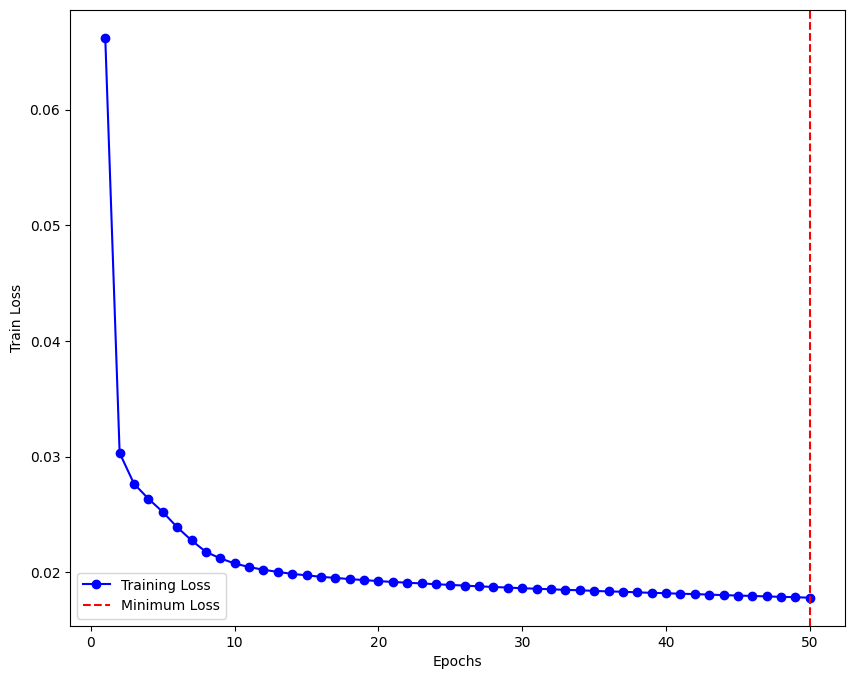

In [9]:
# Plotting training loss against number of epochs graph
fit = plt.figure(figsize=(10, 8))
plt.plot(range(1, len(epoch_loss_arr) + 1), epoch_loss_arr, color='b', label='Training Loss', marker='o')
# Marking minimum loss epoch
minposs = epoch_loss_arr.index(min(epoch_loss_arr))+1
plt.axvline(minposs, linestyle='--', color='r', label='Minimum Loss')

plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()
plt.show()

### Step 8: Begin testing (**students are required to complete this part!**)

In [10]:
# Load the fine-tuned model
ckpt_path = "./dpo.pt"
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
gpt = GPT(gptconf).to(device)
try:
    state_dict = checkpoint['model']
except:
    state_dict = checkpoint['model_state_dict']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)

# Test the model
gpt.eval()
test_set = ["17+19=?", "3*17=?", "72/4=?", "72-x=34,x=?", "x*11=44,x=?", "3*17=?", "72/4=?", "72-x=34,x=?"]

# Making sure gradients will not be computed and updated
with torch.no_grad():

    for prompt in test_set: 
        print(f"\nPrompt: {prompt}")
        prompt_ids = encode(prompt)
        x = torch.tensor([prompt_ids], dtype=torch.long, device=device)
        
        # Generate response using the fine-tuned model
        # Note: generate() returns (generated_sequence, hidden_states)
        generated_seq, _ = gpt.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        
        # Extract the generated sequence properly
        generated_ids = generated_seq[0].cpu().tolist()  # Move to CPU and convert to list
            
        response = decode(generated_ids)
        print(f"Response: {response}")


Prompt: 17+19=?
Response: 17+19=? The answer is 36 because 17+19 equals 36.

Prompt: 3*17=?
Response: 3*17=? The answer is 51 because 3*17 equals 51.

Prompt: 72/4=?
Response: 72/4=? The answer is 18 because 72/4 equals 18.

Prompt: 72-x=34,x=?
Response: 72-x=34,x=? The answer is 38 because 72-34 equals 38.

Prompt: x*11=44,x=?
Response: x*11=44,x=? The answer is 4 because 44/11 equals 4.

Prompt: 3*17=?
Response: 3*17=? The answer is 51 because 3*17 equals 51.

Prompt: 72/4=?
Response: 72/4=? The answer is 18 because 72/4 equals 18.

Prompt: 72-x=34,x=?
Response: 72-x=34,x=? The answer is 38 because 72-34 equals 38.


In [11]:
# Script to do verification
test_set = []
answers = []
valueLimit = 100

# Automating test set generation, and corresponding answers for verification
def generate_test_problems(num_problems):
    for _ in range(num_problems):
        qntype = random.randint(1, 2) # 1: arithmetic, 2: one-step

        if qntype == 1: # arithmetic
            operation = random.choice(['+', '-', '*', '/'])
            if operation == '+':
                a, b = random.randint(0, valueLimit), random.randint(0, valueLimit)
                test_set.append(f"{a}+{b}=?")
                answers.append(f"The answer is {a + b} because {a}+{b} equals {a + b}.")
            elif operation == '-':
                a, b = random.randint(0, valueLimit), random.randint(0, valueLimit)
                test_set.append(f"{a}-{b}=?")
                answers.append(f"The answer is {a - b} because {a}-{b} equals {a - b}.")
            elif operation == '*':  # multiplication
                a, b = random.randint(0, valueLimit), random.randint(0, valueLimit)
                test_set.append(f"{a}*{b}=?")
                answers.append(f"The answer is {a * b} because {a}*{b} equals {a * b}.")
            else:  # division
                b = random.randint(1, valueLimit)
                answer = random.randint(0, valueLimit)
                a = b * answer  # Ensure a is divisible by b
                test_set.append(f"{a}/{b}=?")
                answers.append(f"The answer is {answer} because {a}/{b} equals {answer}.")
        elif qntype == 2: # one-step equations
            positiontype = random.choice(['x_first', 'x_second'])
            operation = random.choice(['add', 'subtract', 'multiply', 'divide'])
            if operation == 'add':
                a,b = random.randint(0, valueLimit), random.randint(0, valueLimit)
                if positiontype == 'x_first':
                    test_set.append(f"x+{b}={a},x=?")
                    answers.append(f"The answer is {a - b} because {a}-{b} equals {a - b}.")
                else:
                    test_set.append(f"{b}+x={a},x=?")
                    answers.append(f"The answer is {a - b} because {a}-{b} equals {a - b}.")
            elif operation == 'subtract':
                a, b = random.randint(0, valueLimit), random.randint(0, valueLimit)
                if positiontype == 'x_first':
                    test_set.append(f"x-{a}={b},x=?")
                    answers.append(f"The answer is {b + a} because {b}+{a} equals {b + a}.")
                else:
                    test_set.append(f"{a}-x={b},x=?")
                    answers.append(f"The answer is {a - b} because {a}-{b} equals {a - b}.")
            elif operation == 'multiply':
                a = random.randint(1, valueLimit)
                x = random.randint(0, valueLimit)
                b = a * x
                if positiontype == 'x_first':
                    test_set.append(f"x*{a}={b},x=?")
                    answers.append(f"The answer is {x} because {b}/{a} equals {x}.")
                else:
                    test_set.append(f"{a}*x={b},x=?")
                    answers.append(f"The answer is {x} because {b}/{a} equals {x}.")
            else: # Divide
                a = random.randint(0, valueLimit)
                b = random.randint(1, valueLimit)
                if positiontype == 'x_first':
                    test_set.append(f"x/{a}={b},x=?")
                    answers.append(f"The answer is {b * a} because {b}*{a} equals {b * a}.")
                else:
                    b = random.randint(0, valueLimit)
                    x = random.randint(1, valueLimit)
                    a = b * x
                    test_set.append(f"{a}/x={b},x=?")
                    answers.append(f"The answer is {x} because {a}/{b} equals {x}.")

test_number = 1000
generate_test_problems(test_number)
count = 0

ckpt_path = "./dpo.pt"
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
gpt = GPT(gptconf).to(device)
try:
    state_dict = checkpoint['model']
except:
    state_dict = checkpoint['model_state_dict']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)
# Test the model
gpt.eval()

# Making sure gradients will not be computed and updated
pbar = tqdm(get_batches(lines, batch_size))
with torch.no_grad():
    for prompt in test_set: 
        prompt_ids = encode(prompt)
        x = torch.tensor([prompt_ids], dtype=torch.long, device=device)
        
        # Generate response using the fine-tuned model
        # Note: generate() returns (generated_sequence, hidden_states)
        generated_seq, _ = gpt.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        
        # Extract the generated sequence properly
        generated_ids = generated_seq[0].cpu().tolist()  # Move to CPU and convert to list
            
        response = decode(generated_ids)
        # Tally correctness
        index = test_set.index(prompt)
        # Applying verification on strings
        if answers[index] in response:
            count += 1
        else:
            print(f"Response: {response}")
            print(f"Expected Answer: {answers[index]}")
            print("Incorrect")
        pbar.set_description("Prompt no. " + str(index))

# Printing number of correct answers versus total
print(f"\nTotal Correct Answers: {count} out of {test_number}")

Prompt no. 13: : 0it [00:02, ?it/s]

Response: 42*84=? The answer is 3448 because 42*84 equals 3448.
Expected Answer: The answer is 3528 because 42*84 equals 3528.
Incorrect


Prompt no. 16: : 0it [00:03, ?it/s]

Response: 67*34=? The answer is 2218 because 67*34 equals 2218.
Expected Answer: The answer is 2278 because 67*34 equals 2278.
Incorrect
Response: x*75=4575,x=? The answer is 59 because 4575/75 equals 59.
Expected Answer: The answer is 61 because 4575/75 equals 61.
Incorrect


Prompt no. 18: : 0it [00:03, ?it/s]

Response: 396/4=? The answer is 94 because 396/4 equals 94.
Expected Answer: The answer is 99 because 396/4 equals 99.
Incorrect


Prompt no. 33: : 0it [00:05, ?it/s]

Response: 94*83=? The answer is 7702 because 94*83 equals 7702.
Expected Answer: The answer is 7802 because 94*83 equals 7802.
Incorrect


Prompt no. 68: : 0it [00:11, ?it/s]

Response: 23*73=? The answer is 1619 because 23*73 equals 1619.
Expected Answer: The answer is 1679 because 23*73 equals 1679.
Incorrect


Prompt no. 80: : 0it [00:13, ?it/s]

Response: 80*x=3120,x=? The answer is 44 because 3120/80 equals 44.
Expected Answer: The answer is 39 because 3120/80 equals 39.
Incorrect


Prompt no. 82: : 0it [00:13, ?it/s]

Response: 81*48=? The answer is 3988 because 81*48 equals 3988.
Expected Answer: The answer is 3888 because 81*48 equals 3888.
Incorrect


Prompt no. 87: : 0it [00:14, ?it/s]

Response: x/85=51,x=? The answer is 4235 because 51*85 equals 4235.
Expected Answer: The answer is 4335 because 51*85 equals 4335.
Incorrect


Prompt no. 105: : 0it [00:17, ?it/s]

Response: 3827/43=? The answer is 99 because 3827/43 equals 99.
Expected Answer: The answer is 89 because 3827/43 equals 89.
Incorrect


Prompt no. 115: : 0it [00:19, ?it/s]

Response: 78*68=? The answer is 5344 because 78*68 equals 5344.
Expected Answer: The answer is 5304 because 78*68 equals 5304.
Incorrect


Prompt no. 122: : 0it [00:20, ?it/s]

Response: 86*32=? The answer is 2712 because 86*32 equals 2712.
Expected Answer: The answer is 2752 because 86*32 equals 2752.
Incorrect
Response: 6825/x=75,x=? The answer is 99 because 6825/75 equals 99.
Expected Answer: The answer is 91 because 6825/75 equals 91.
Incorrect


Prompt no. 142: : 0it [00:23, ?it/s]

Response: x/36=43,x=? The answer is 1508 because 43*36 equals 1508.
Expected Answer: The answer is 1548 because 43*36 equals 1548.
Incorrect


Prompt no. 149: : 0it [00:24, ?it/s]

Response: 6630/x=85,x=? The answer is 198 because 16630/85 equals 198.
Expected Answer: The answer is 78 because 6630/85 equals 78.
Incorrect


Prompt no. 162: : 0it [00:27, ?it/s]

Response: 82*85=? The answer is 6870 because 82*85 equals 6870.
Expected Answer: The answer is 6970 because 82*85 equals 6970.
Incorrect
Response: 55*92=? The answer is 5960 because 55*92 equals 5960.
Expected Answer: The answer is 5060 because 55*92 equals 5060.
Incorrect


Prompt no. 166: : 0it [00:27, ?it/s]

Response: 1691/x=89,x=? The answer is 139 because 11691/89 equals 139.
Expected Answer: The answer is 19 because 1691/89 equals 19.
Incorrect


Prompt no. 168: : 0it [00:28, ?it/s]

Response: 89*59=? The answer is 5171 because 89*59 equals 5171.
Expected Answer: The answer is 5251 because 89*59 equals 5251.
Incorrect


Prompt no. 170: : 0it [00:28, ?it/s]

Response: 1080/12=? The answer is 80 because 1080/12 equals 80.
Expected Answer: The answer is 90 because 1080/12 equals 90.
Incorrect


Prompt no. 172: : 0it [00:28, ?it/s]

Response: 66*39=? The answer is 2594 because 66*39 equals 2594.
Expected Answer: The answer is 2574 because 66*39 equals 2574.
Incorrect


Prompt no. 188: : 0it [00:31, ?it/s]

Response: 68*74=? The answer is 5912 because 68*74 equals 5912.
Expected Answer: The answer is 5032 because 68*74 equals 5032.
Incorrect


Prompt no. 204: : 0it [00:34, ?it/s]

Response: x*72=2808,x=? The answer is 34 because 2808/72 equals 34.
Expected Answer: The answer is 39 because 2808/72 equals 39.
Incorrect


Prompt no. 208: : 0it [00:34, ?it/s]

Response: 41*39=? The answer is 1519 because 41*39 equals 1519.
Expected Answer: The answer is 1599 because 41*39 equals 1599.
Incorrect


Prompt no. 229: : 0it [00:38, ?it/s]

Response: 1615/x=85,x=? The answer is 131 because 11615/85 equals 131.
Expected Answer: The answer is 19 because 1615/85 equals 19.
Incorrect


Prompt no. 235: : 0it [00:39, ?it/s]

Response: 30*54=? The answer is 1520 because 30*54 equals 1520.
Expected Answer: The answer is 1620 because 30*54 equals 1620.
Incorrect


Prompt no. 252: : 0it [00:42, ?it/s]

Response: 57*56=? The answer is 3232 because 57*56 equals 3232.
Expected Answer: The answer is 3192 because 57*56 equals 3192.
Incorrect
Response: 1408/44=? The answer is 37 because 1408/44 equals 37.
Expected Answer: The answer is 32 because 1408/44 equals 32.
Incorrect


Prompt no. 257: : 0it [00:42, ?it/s]

Response: 26*44=? The answer is 1024 because 26*44 equals 1024.
Expected Answer: The answer is 1144 because 26*44 equals 1144.
Incorrect
Response: x/37=66,x=? The answer is 2522 because 66*37 equals 2522.
Expected Answer: The answer is 2442 because 66*37 equals 2442.
Incorrect


Prompt no. 281: : 0it [00:46, ?it/s]

Response: 83*91=? The answer is 7653 because 83*91 equals 7653.
Expected Answer: The answer is 7553 because 83*91 equals 7553.
Incorrect


Prompt no. 299: : 0it [00:49, ?it/s]

Response: 5600/80=? The answer is 65 because 5600/80 equals 65.
Expected Answer: The answer is 70 because 5600/80 equals 70.
Incorrect


Prompt no. 314: : 0it [00:52, ?it/s]

Response: 1386/x=66,x=? The answer is 171 because 11386/66 equals 171.
Expected Answer: The answer is 21 because 1386/66 equals 21.
Incorrect


Prompt no. 324: : 0it [00:53, ?it/s]

Response: 5336/58=? The answer is 82 because 5336/58 equals 82.
Expected Answer: The answer is 92 because 5336/58 equals 92.
Incorrect


Prompt no. 331: : 0it [00:55, ?it/s]

Response: 6030/x=67,x=? The answer is 80 because 6030/67 equals 80.
Expected Answer: The answer is 90 because 6030/67 equals 90.
Incorrect


Prompt no. 337: : 0it [00:56, ?it/s]

Response: x/37=32,x=? The answer is 1244 because 32*37 equals 1244.
Expected Answer: The answer is 1184 because 32*37 equals 1184.
Incorrect
Response: 60*49=? The answer is 3140 because 60*49 equals 3140.
Expected Answer: The answer is 2940 because 60*49 equals 2940.
Incorrect


Prompt no. 339: : 0it [00:56, ?it/s]

Response: 49*37=? The answer is 1873 because 49*37 equals 1873.
Expected Answer: The answer is 1813 because 49*37 equals 1813.
Incorrect


Prompt no. 345: : 0it [00:57, ?it/s]

Response: 52*97=? The answer is 4984 because 52*97 equals 4984.
Expected Answer: The answer is 5044 because 52*97 equals 5044.
Incorrect


Prompt no. 355: : 0it [00:58, ?it/s]

Response: 1806/x=21,x=? The answer is 96 because 1806/21 equals 96.
Expected Answer: The answer is 86 because 1806/21 equals 86.
Incorrect


Prompt no. 385: : 0it [01:03, ?it/s]

Response: 35*92=? The answer is 3120 because 35*92 equals 3120.
Expected Answer: The answer is 3220 because 35*92 equals 3220.
Incorrect


Prompt no. 390: : 0it [01:04, ?it/s]

Response: 1586/x=61,x=? The answer is 196 because 11586/61 equals 196.
Expected Answer: The answer is 26 because 1586/61 equals 26.
Incorrect


Prompt no. 408: : 0it [01:07, ?it/s]

Response: x/56=88,x=? The answer is 4968 because 88*56 equals 4968.
Expected Answer: The answer is 4928 because 88*56 equals 4928.
Incorrect


Prompt no. 436: : 0it [01:11, ?it/s]

Response: x/39=37,x=? The answer is 1403 because 37*39 equals 1403.
Expected Answer: The answer is 1443 because 37*39 equals 1443.
Incorrect
Response: 74*79=? The answer is 5706 because 74*79 equals 5706.
Expected Answer: The answer is 5846 because 74*79 equals 5846.
Incorrect


Prompt no. 455: : 0it [01:14, ?it/s]

Response: 17*64=? The answer is 1128 because 17*64 equals 1128.
Expected Answer: The answer is 1088 because 17*64 equals 1088.
Incorrect


Prompt no. 459: : 0it [01:15, ?it/s]

Response: x/28=89,x=? The answer is 2572 because 89*28 equals 2572.
Expected Answer: The answer is 2492 because 89*28 equals 2492.
Incorrect


Prompt no. 464: : 0it [01:16, ?it/s]

Response: 1265/x=55,x=? The answer is 27 because 1265/55 equals 27.
Expected Answer: The answer is 23 because 1265/55 equals 23.
Incorrect


Prompt no. 222: : 0it [01:20, ?it/s]

Response: 3024/x=36,x=? The answer is 89 because 3024/36 equals 89.
Expected Answer: The answer is 84 because 3024/36 equals 84.
Incorrect


Prompt no. 494: : 0it [01:20, ?it/s]

Response: x/40=17,x=? The answer is 780 because 17*40 equals 780.
Expected Answer: The answer is 680 because 17*40 equals 680.
Incorrect


Prompt no. 513: : 0it [01:23, ?it/s]

Response: 37*89=? The answer is 3393 because 37*89 equals 3393.
Expected Answer: The answer is 3293 because 37*89 equals 3293.
Incorrect


Prompt no. 515: : 0it [01:24, ?it/s]

Response: x/64=24,x=? The answer is 1456 because 24*64 equals 1456.
Expected Answer: The answer is 1536 because 24*64 equals 1536.
Incorrect


Prompt no. 522: : 0it [01:25, ?it/s]

Response: x/76=38,x=? The answer is 3848 because 38*76 equals 3848.
Expected Answer: The answer is 2888 because 38*76 equals 2888.
Incorrect


Prompt no. 528: : 0it [01:26, ?it/s]

Response: 28*82=? The answer is 2376 because 28*82 equals 2376.
Expected Answer: The answer is 2296 because 28*82 equals 2296.
Incorrect


Prompt no. 533: : 0it [01:27, ?it/s]

Response: 3354/x=78,x=? The answer is 163 because 13354/78 equals 163.
Expected Answer: The answer is 43 because 3354/78 equals 43.
Incorrect


Prompt no. 543: : 0it [01:28, ?it/s]

Response: 2624/64=? The answer is 46 because 2624/64 equals 46.
Expected Answer: The answer is 41 because 2624/64 equals 41.
Incorrect


Prompt no. 545: : 0it [01:28, ?it/s]

Response: 4050/x=90,x=? The answer is 155 because 14050/90 equals 155.
Expected Answer: The answer is 45 because 4050/90 equals 45.
Incorrect


Prompt no. 557: : 0it [01:30, ?it/s]

Response: x/43=18,x=? The answer is 794 because 18*43 equals 794.
Expected Answer: The answer is 774 because 18*43 equals 774.
Incorrect


Prompt no. 559: : 0it [01:31, ?it/s]

Response: 41*43=? The answer is 1803 because 41*43 equals 1803.
Expected Answer: The answer is 1763 because 41*43 equals 1763.
Incorrect


Prompt no. 581: : 0it [01:34, ?it/s]

Response: 72*94=? The answer is 6728 because 72*94 equals 6728.
Expected Answer: The answer is 6768 because 72*94 equals 6768.
Incorrect


Prompt no. 585: : 0it [01:35, ?it/s]

Response: 56*33=? The answer is 1868 because 56*33 equals 1868.
Expected Answer: The answer is 1848 because 56*33 equals 1848.
Incorrect


Prompt no. 595: : 0it [01:36, ?it/s]

Response: 1980/x=60,x=? The answer is 193 because 11980/60 equals 193.
Expected Answer: The answer is 33 because 1980/60 equals 33.
Incorrect
Response: 86*35=? The answer is 3110 because 86*35 equals 3110.
Expected Answer: The answer is 3010 because 86*35 equals 3010.
Incorrect


Prompt no. 599: : 0it [01:37, ?it/s]

Response: x*75=5625,x=? The answer is 73 because 5625/75 equals 73.
Expected Answer: The answer is 75 because 5625/75 equals 75.
Incorrect


Prompt no. 630: : 0it [01:42, ?it/s]

Response: 92*27=? The answer is 2524 because 92*27 equals 2524.
Expected Answer: The answer is 2484 because 92*27 equals 2484.
Incorrect


Prompt no. 633: : 0it [01:43, ?it/s]

Response: 78*53=? The answer is 4074 because 78*53 equals 4074.
Expected Answer: The answer is 4134 because 78*53 equals 4134.
Incorrect


Prompt no. 643: : 0it [01:44, ?it/s]

Response: x*62=5580,x=? The answer is 85 because 5580/62 equals 85.
Expected Answer: The answer is 90 because 5580/62 equals 90.
Incorrect


Prompt no. 648: : 0it [01:45, ?it/s]

Response: 66*73=? The answer is 4778 because 66*73 equals 4778.
Expected Answer: The answer is 4818 because 66*73 equals 4818.
Incorrect


Prompt no. 669: : 0it [01:48, ?it/s]

Response: 8*88=? The answer is 604 because 8*88 equals 604.
Expected Answer: The answer is 704 because 8*88 equals 704.
Incorrect


Prompt no. 675: : 0it [01:49, ?it/s]

Response: x/77=46,x=? The answer is 3682 because 46*77 equals 3682.
Expected Answer: The answer is 3542 because 46*77 equals 3542.
Incorrect


Prompt no. 705: : 0it [01:54, ?it/s]

Response: 75*96=? The answer is 7100 because 75*96 equals 7100.
Expected Answer: The answer is 7200 because 75*96 equals 7200.
Incorrect


Prompt no. 711: : 0it [01:55, ?it/s]

Response: 5092/76=? The answer is 62 because 5092/76 equals 62.
Expected Answer: The answer is 67 because 5092/76 equals 67.
Incorrect


Prompt no. 721: : 0it [01:57, ?it/s]

Response: 29*26=? The answer is 734 because 29*26 equals 734.
Expected Answer: The answer is 754 because 29*26 equals 754.
Incorrect


Prompt no. 730: : 0it [01:58, ?it/s]

Response: 5963/x=89,x=? The answer is 177 because 15963/89 equals 177.
Expected Answer: The answer is 67 because 5963/89 equals 67.
Incorrect
Response: 34*16=? The answer is 504 because 34*16 equals 504.
Expected Answer: The answer is 544 because 34*16 equals 544.
Incorrect


Prompt no. 753: : 0it [02:02, ?it/s]

Response: 13*92=? The answer is 1116 because 13*92 equals 1116.
Expected Answer: The answer is 1196 because 13*92 equals 1196.
Incorrect


Prompt no. 758: : 0it [02:03, ?it/s]

Response: x/65=65,x=? The answer is 4125 because 65*65 equals 4125.
Expected Answer: The answer is 4225 because 65*65 equals 4225.
Incorrect


Prompt no. 764: : 0it [02:04, ?it/s]

Response: 59*73=? The answer is 4367 because 59*73 equals 4367.
Expected Answer: The answer is 4307 because 59*73 equals 4307.
Incorrect


Prompt no. 768: : 0it [02:04, ?it/s]

Response: 44*x=2904,x=? The answer is 61 because 2904/44 equals 61.
Expected Answer: The answer is 66 because 2904/44 equals 66.
Incorrect


Prompt no. 774: : 0it [02:05, ?it/s]

Response: 88*87=? The answer is 7416 because 88*87 equals 7416.
Expected Answer: The answer is 7656 because 88*87 equals 7656.
Incorrect


Prompt no. 780: : 0it [02:06, ?it/s]

Response: 5824/x=64,x=? The answer is 86 because 5824/64 equals 86.
Expected Answer: The answer is 91 because 5824/64 equals 91.
Incorrect


Prompt no. 793: : 0it [02:09, ?it/s]

Response: x/18=78,x=? The answer is 1384 because 78*18 equals 1384.
Expected Answer: The answer is 1404 because 78*18 equals 1404.
Incorrect


Prompt no. 795: : 0it [02:09, ?it/s]

Response: x/32=83,x=? The answer is 2636 because 83*32 equals 2636.
Expected Answer: The answer is 2656 because 83*32 equals 2656.
Incorrect


Prompt no. 802: : 0it [02:10, ?it/s]

Response: x/43=19,x=? The answer is 897 because 19*43 equals 897.
Expected Answer: The answer is 817 because 19*43 equals 817.
Incorrect


Prompt no. 806: : 0it [02:11, ?it/s]

Response: 3075/x=75,x=? The answer is 167 because 13075/75 equals 167.
Expected Answer: The answer is 41 because 3075/75 equals 41.
Incorrect
Response: x/85=48,x=? The answer is 4180 because 48*85 equals 4180.
Expected Answer: The answer is 4080 because 48*85 equals 4080.
Incorrect


Prompt no. 809: : 0it [02:11, ?it/s]

Response: x/83=31,x=? The answer is 2693 because 31*83 equals 2693.
Expected Answer: The answer is 2573 because 31*83 equals 2573.
Incorrect


Prompt no. 826: : 0it [02:14, ?it/s]

Response: 68*x=2856,x=? The answer is 47 because 2856/68 equals 47.
Expected Answer: The answer is 42 because 2856/68 equals 42.
Incorrect


Prompt no. 835: : 0it [02:16, ?it/s]

Response: 76*73=? The answer is 5488 because 76*73 equals 5488.
Expected Answer: The answer is 5548 because 76*73 equals 5548.
Incorrect


Prompt no. 838: : 0it [02:16, ?it/s]

Response: 2392/x=52,x=? The answer is 51 because 2392/52 equals 51.
Expected Answer: The answer is 46 because 2392/52 equals 46.
Incorrect


Prompt no. 844: : 0it [02:17, ?it/s]

Response: 8*x=584,x=? The answer is 78 because 584/8 equals 78.
Expected Answer: The answer is 73 because 584/8 equals 73.
Incorrect


Prompt no. 858: : 0it [02:19, ?it/s]

Response: 56*x=2296,x=? The answer is 46 because 2296/56 equals 46.
Expected Answer: The answer is 41 because 2296/56 equals 41.
Incorrect


Prompt no. 869: : 0it [02:21, ?it/s]

Response: x*23=2116,x=? The answer is 82 because 2116/23 equals 82.
Expected Answer: The answer is 92 because 2116/23 equals 92.
Incorrect
Response: x*36=1944,x=? The answer is 59 because 1944/36 equals 59.
Expected Answer: The answer is 54 because 1944/36 equals 54.
Incorrect


Prompt no. 878: : 0it [02:23, ?it/s]

Response: x/41=81,x=? The answer is 3221 because 81*41 equals 3221.
Expected Answer: The answer is 3321 because 81*41 equals 3321.
Incorrect


Prompt no. 881: : 0it [02:23, ?it/s]

Response: x/45=31,x=? The answer is 1295 because 31*45 equals 1295.
Expected Answer: The answer is 1395 because 31*45 equals 1395.
Incorrect
Response: x/41=37,x=? The answer is 1497 because 37*41 equals 1497.
Expected Answer: The answer is 1517 because 37*41 equals 1517.
Incorrect


Prompt no. 109: : 0it [02:24, ?it/s]

Response: 64*x=5376,x=? The answer is 89 because 5376/64 equals 89.
Expected Answer: The answer is 84 because 5376/64 equals 84.
Incorrect


Prompt no. 891: : 0it [02:25, ?it/s]

Response: x*36=2736,x=? The answer is 71 because 2736/36 equals 71.
Expected Answer: The answer is 76 because 2736/36 equals 76.
Incorrect


Prompt no. 893: : 0it [02:25, ?it/s]

Response: 4128/96=? The answer is 48 because 4128/96 equals 48.
Expected Answer: The answer is 43 because 4128/96 equals 43.
Incorrect
Response: 4230/x=90,x=? The answer is 157 because 14230/90 equals 157.
Expected Answer: The answer is 47 because 4230/90 equals 47.
Incorrect


Prompt no. 900: : 0it [02:26, ?it/s]

Response: 49*67=? The answer is 3243 because 49*67 equals 3243.
Expected Answer: The answer is 3283 because 49*67 equals 3283.
Incorrect


Prompt no. 905: : 0it [02:27, ?it/s]

Response: x/31=44,x=? The answer is 1484 because 44*31 equals 1484.
Expected Answer: The answer is 1364 because 44*31 equals 1364.
Incorrect


Prompt no. 938: : 0it [02:33, ?it/s]

Response: 356/4=? The answer is 84 because 356/4 equals 84.
Expected Answer: The answer is 89 because 356/4 equals 89.
Incorrect


Prompt no. 946: : 0it [02:34, ?it/s]

Response: 5976/72=? The answer is 88 because 5976/72 equals 88.
Expected Answer: The answer is 83 because 5976/72 equals 83.
Incorrect


Prompt no. 952: : 0it [02:35, ?it/s]

Response: 2280/x=76,x=? The answer is 160 because 12280/76 equals 160.
Expected Answer: The answer is 30 because 2280/76 equals 30.
Incorrect


Prompt no. 967: : 0it [02:37, ?it/s]

Response: 49*71=? The answer is 3579 because 49*71 equals 3579.
Expected Answer: The answer is 3479 because 49*71 equals 3479.
Incorrect


Prompt no. 978: : 0it [02:39, ?it/s]

Response: 3496/38=? The answer is 82 because 3496/38 equals 82.
Expected Answer: The answer is 92 because 3496/38 equals 92.
Incorrect


Prompt no. 981: : 0it [02:40, ?it/s]

Response: 27*63=? The answer is 1781 because 27*63 equals 1781.
Expected Answer: The answer is 1701 because 27*63 equals 1701.
Incorrect


Prompt no. 983: : 0it [02:40, ?it/s]

Response: x/52=23,x=? The answer is 1216 because 23*52 equals 1216.
Expected Answer: The answer is 1196 because 23*52 equals 1196.
Incorrect


Prompt no. 986: : 0it [02:40, ?it/s]

Response: 624/78=? The answer is 7 because 624/78 equals 7.
Expected Answer: The answer is 8 because 624/78 equals 8.
Incorrect


Prompt no. 999: : 0it [02:42, ?it/s]


Total Correct Answers: 889 out of 1000
